In [22]:
import pennylane as qml
import torch

n_wires = 4

torch.manual_seed(42)
weights = torch.ones((n_wires,3), requires_grad=True)
bias = torch.zeros(1, requires_grad=True)
params = {"weights": weights, "bias": bias}
opt = torch.optim.Adam([ weights, bias], lr=0.1)
loss_history = []


@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def circuit(x, weights):

    # Embedding Ansatz
    for i in range(n_wires):
        qml.RY(2*torch.arccos(x),wires = i)

    # Variational Ansatz   
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_wires])

    # Total magnetization in z-direction as cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(data, weights, bias):
    return circuit(data, weights) + bias

def loss_fnc(params):
    # Loss function of: du/dx = 1, u(0) = 0
    x = torch.linspace(0,0.99,11,requires_grad=True)
    u_pred = my_model(x, params["weights"], params["bias"])
    grad_outputs = torch.ones_like(u_pred)
    dudx = torch.autograd.grad(u_pred, x, grad_outputs=grad_outputs, create_graph=True)[0]
    
    loss_diff = torch.mean((dudx - torch.ones_like(dudx))**2)
    loss_initial = torch.mean(my_model(torch.zeros_like(x),params["weights"], params["bias"])**2)
    
    return loss_diff + loss_initial

def optimize(params, n=1000):
    loss_history = []

    for i in range(1,n+1):
        opt.zero_grad()
        loss_val = loss_fnc(params)
        loss_val.backward()
        opt.step()
        if i%100 == 0: print(f"Step: {i}  Loss: {loss_val}")
        loss_history.append(loss_val)

    return params, loss_history

%timeit -r1 -n1 optimize(params)

Step: 100  Loss: 0.2836303651903658
Step: 200  Loss: 0.07566650874956893
Step: 300  Loss: 0.06001541040679609
Step: 400  Loss: 0.09115942112093567
Step: 500  Loss: 0.025740651404907347
Step: 600  Loss: 0.012161103188808007
Step: 700  Loss: 0.011346832105999086
Step: 800  Loss: 0.03036155840469407
Step: 900  Loss: 0.010829485969516772
Step: 1000  Loss: 0.013612815638004542
37.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Step: 100  Loss: 1.3770444839197502
Step: 200  Loss: 0.9908921647046446
Step: 300  Loss: 0.9248054679038203
Step: 400  Loss: 0.617095411815459
Step: 500  Loss: 0.2755456521224211
Step: 600  Loss: 0.15425580148525686
Step: 700  Loss: 0.11889191732790128
Step: 800  Loss: 0.10590268498698663
Step: 900  Loss: 0.10049042753623016
Step: 1000  Loss: 0.09803225022496065
36.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


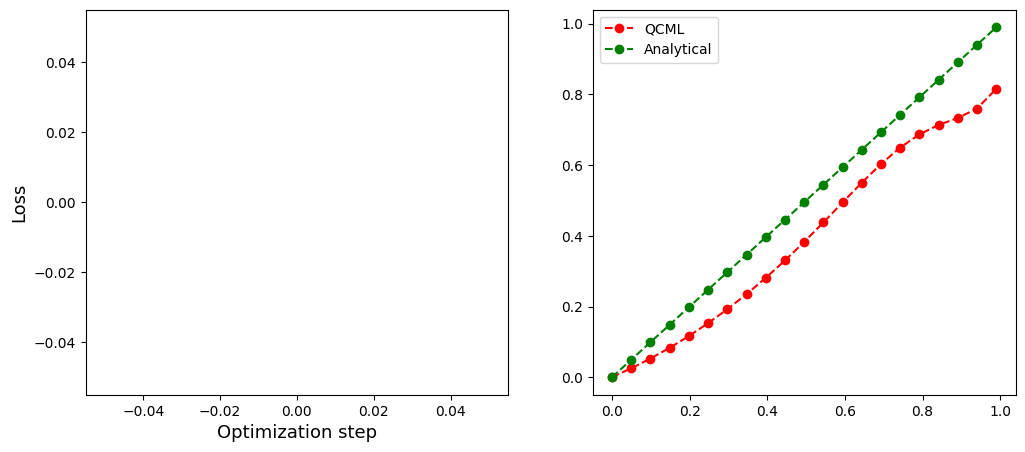

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = torch.linspace(0,0.99,21)
f_qc = my_model(x,params["weights"], params["bias"]).detach()
f_an = x
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()